In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import dates
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.mplot3d import Axes3D
from netCDF4 import num2date,date2num,Dataset
from scipy.stats import pearsonr
import scipy,matplotlib
import skimage.measure as skm
import pyart
import copy
import os, subprocess, time
import pyproj
from mpl_toolkits.basemap import Basemap
from joblib import Parallel, delayed
import datetime
import mahotas,pymorph,pylab
import scipy.ndimage as ndi
import pandas as pd
import cPickle as pickle
import matplotlib.gridspec as gridspec
from marcus_py_tools import haversine,find_stuff_at_level,walklevel,latlon_from_xy,xy_from_latlon,make_edge_vec
%matplotlib inline

# Test Spatial Statistics
July 15 2016 - this serves as a testbed for quantifying the spatial organization of convective cells in groupings of thunderstorms, e.g. in MCS or whatever. Multiple tests will be made to see how well each metric quantifies what we're looking for. What are we looking for? 
- Spacing of cells (nearest neighbor?)
- Number of cells (spatial density within convective region?)
- How wide is the line (???)
The first has been coded and tested. The second requires implementation of some convective/stratiform partition code. This can be adapted from pre-existing code, or coded fresh. The third will require some experimentation

## How wide is the line?
We will play around with a distance transform applied to identified KDP columns or updraft features.

In [10]:
zhhnm     = 'reflectivity'
zdrnm     = 'differential_reflectivity'
kdpnm     = 'kdp'
rhonm     = 'cross_correlation_ratio'
zaxnm     = 'z_disp'
hfmt = dates.DateFormatter('%H:%M')
zsfc = 340.

In [6]:
filepath = '/home/mvanlier/mvanlier/nexrad_kvnx_520/'
filepre = 'grid2'
#..Get list of files
radfiles = []
numfiles = 0
epocs = []
for root,dirs,files in walklevel(filepath,level=0):
    for file in files:
        if file.startswith(filepre):
            radfiles.append(file)
            numfiles +=1
radfiles = sorted(radfiles)
print 'numfiles=',numfiles
print radfiles[60]

numfiles= 150
grid2_kvnx20110520_102327.nc


In [26]:
filenm = radfiles[55]
#..Load data, look at it
epoc  = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                               int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
             datetime.datetime(1970,1,1)).total_seconds()
#..Load data from file
nc = Dataset(filepath+filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables[zaxnm][:]
alt= zd + zsfc
xgrid = np.tile(xd,(len(yd),1))
ygrid = np.tile(yd,(len(xd),1))
ygrid = ygrid.T
zhh = nc.variables[zhhnm][0,:,:,:]
zdr = nc.variables[zdrnm][0,:,:,:]
kdp = nc.variables[kdpnm][0,:,:,:]
rho = nc.variables[rhonm][0,:,:,:]
nc.close()

3960.68965517


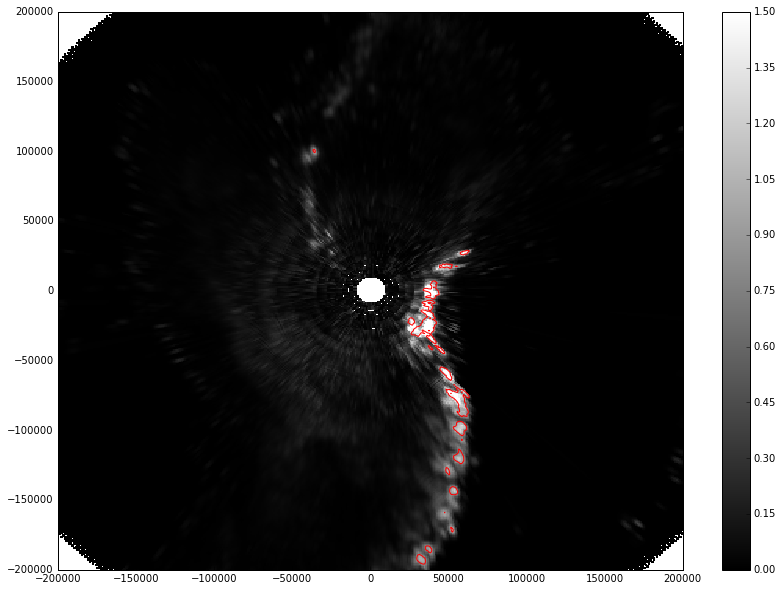

In [30]:
lev=7
fig = plt.figure(figsize=(14,10))
ab=plt.pcolormesh(xd,yd,kdp[lev,:,:],cmap=cm.gray,vmin=0,vmax=1.5)
plt.contour(xd,yd,kdp[8,:,:],levels=[0.75,],colors=['r',])
plt.colorbar(ab)
#..
print alt[lev]
#..

As can be seen, the convective line, as defined by KDP, is very narrow. Let's pick out the KDP columns and then play around with the distance transform

In [35]:
threshold=4.5
blurval=0.9
leveloff=1
levelup=6
leveldown=0
kdpthr=.75
altmelt = 3900.

meltlev = min(range(len(alt)),key=lambda i:abs(alt[i]-altmelt))
print meltlev
#..Find the kdp objects of interest
kdp_proc = copy.deepcopy(kdp)
kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
#     kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
#     kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
#..Get KDP objects
kdp_seeds,nobj,kdpi,kdpif,kdp_obj = find_stuff_at_level(kdp_proc,meltlev,threshold,blurval,
                                                       leveloff  = leveloff,
                                                       levelup   = levelup,
                                                       leveldown = leveldown,
                                                       debug     = True,
                                                       newseg    = True,erodedilate = False)

7


11


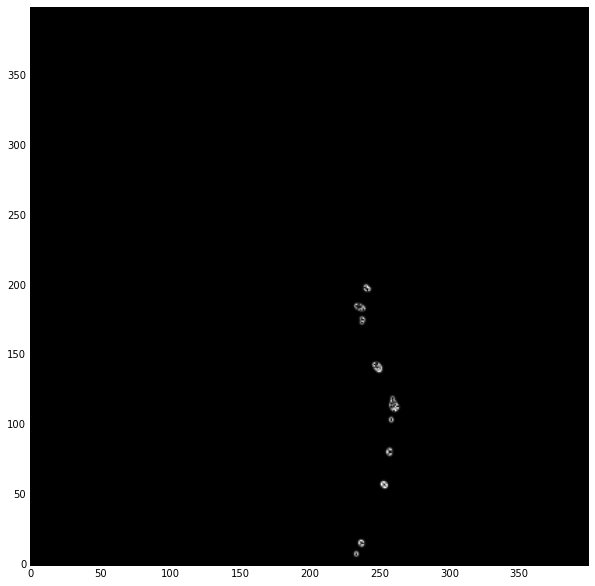

In [34]:
rmax = copy.deepcopy(kdp_seeds)
rmax[rmax>1]=1
fig = plt.figure(figsize=(14,10))
pylab.imshow(pymorph.overlay(kdpif,rmax),origin='lower')
print nobj

In [55]:
objst = copy.deepcopy(kdp_seeds)
objst[kdp_seeds==0]=1
objst[kdp_seeds>0]=False
dmap = np.sqrt(mahotas.distance(objst))

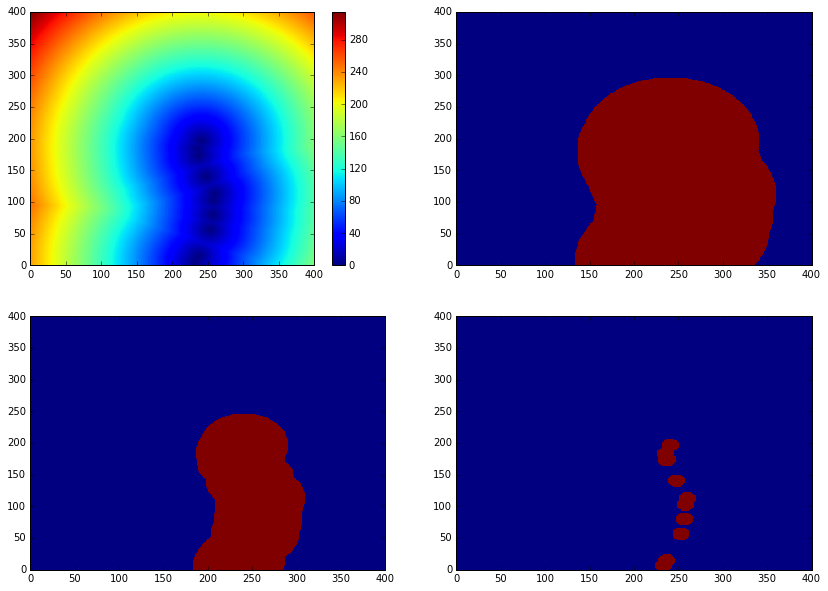

In [58]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ab=ax1.pcolormesh(dmap)
plt.colorbar(ab)
ax2 = fig.add_subplot(2,2,2)
ax2.pcolormesh(dmap<100.)
ax3 = fig.add_subplot(2,2,3)
ax3.pcolormesh(dmap<50.)
ax4 = fig.add_subplot(2,2,4)
ax4.pcolormesh(dmap<10.)

In [63]:
#...Cacalate how area and perimeter of the enclosed region scale with distance
darr = np.linspace(1.,100.,num=100)
darea = []
dperm = []
for i in xrange(darr.shape[0]):
    dum = dmap<darr[i]
    darea = np.r_[darea,dum.sum()]
    dperm = np.r_[dperm,skm.perimeter(dum)]

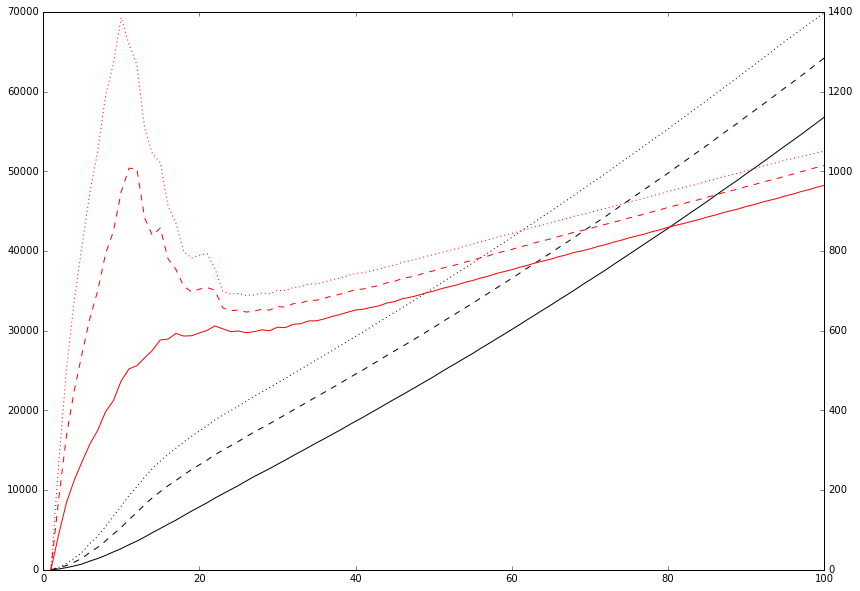

In [77]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(darr,darea,'k')
ax1.plot(darr,darea2,'k--')
ax1.plot(darr,darea3,'k:')
ax2 = ax1.twinx()
ax2.plot(darr,dperm,'r')
ax2.plot(darr,dperm2,'r--')
ax2.plot(darr,dperm3,'r:')
#..

In [71]:
#..Now try this with a shifted array (you'll see what I mean)
kdps2 = np.roll(kdp_seeds,25,axis=1) + kdp_seeds
objst2 = copy.deepcopy(kdps2)
objst2[kdps2==0]=1
objst2[kdps2>0]=False
dmap2 = np.sqrt(mahotas.distance(objst2))

In [75]:
#..Now try this with a shifted array (you'll see what I mean)
kdps3 = np.roll(kdp_seeds,45,axis=1)+np.roll(kdp_seeds,25,axis=1) + kdp_seeds
objst3 = copy.deepcopy(kdps3)
objst3[kdps3==0]=1
objst3[kdps3>0]=False
dmap3 = np.sqrt(mahotas.distance(objst3))

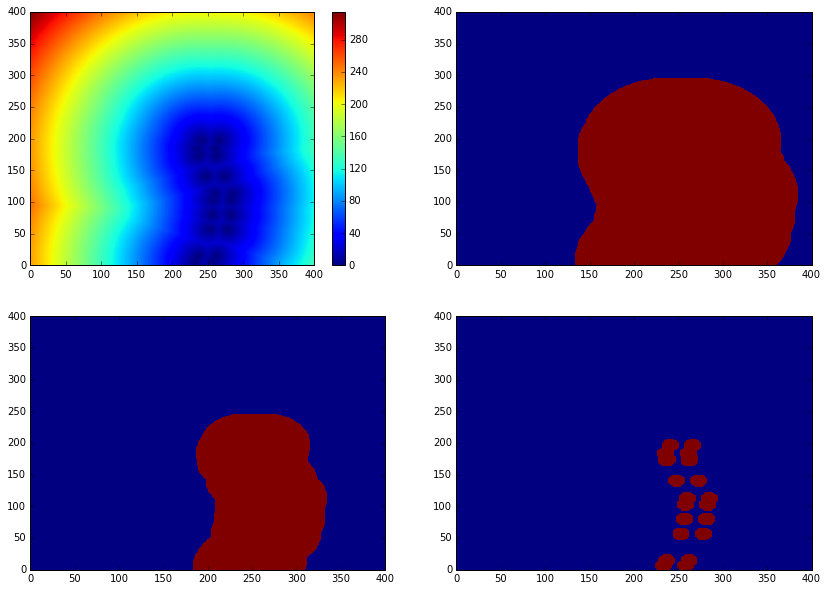

In [72]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ab=ax1.pcolormesh(dmap2)
plt.colorbar(ab)
ax2 = fig.add_subplot(2,2,2)
ax2.pcolormesh(dmap2<100.)
ax3 = fig.add_subplot(2,2,3)
ax3.pcolormesh(dmap2<50.)
ax4 = fig.add_subplot(2,2,4)
ax4.pcolormesh(dmap2<10.)

In [73]:
#...Cacalate how area and perimeter of the enclosed region scale with distance
#darr = np.linspace(1.,100.,num=100)
darea2 = []
dperm2 = []
for i in xrange(darr.shape[0]):
    dum = dmap2<darr[i]
    darea2 = np.r_[darea2,dum.sum()]
    dperm2 = np.r_[dperm2,skm.perimeter(dum)]

In [76]:
#...Cacalate how area and perimeter of the enclosed region scale with distance
#darr = np.linspace(1.,100.,num=100)
darea3 = []
dperm3 = []
for i in xrange(darr.shape[0]):
    dum = dmap3<darr[i]
    darea3 = np.r_[darea3,dum.sum()]
    dperm3 = np.r_[dperm3,skm.perimeter(dum)]

# JUNKY STUFF BELOW

In [38]:
def normalize_array(array_in,minval=0,maxval=255,integerout=True,invert=False):
    array_out = copy.deepcopy(array_in)
    array_out[array_out<0.] = 0.  #..Here is subzero, now plain zero
    #..we lazily assume the minimum is zero...
    array_out = maxval*array_out/(array_out.max())
    if integerout:
        array_out = array_out.astype(np.uint8)
    if invert:
        array_out = maxval-array_out
    return array_out

In [39]:
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]
kdp_proc = copy.deepcopy(kdp)
kdp_proc[rho<.8] = 0.
kdp_proc[zhh<15.] = 0.
kdp_proc[kdp_proc==-9999.] = 0.
#kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
#kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
#kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
#kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
#kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

vol_ones = kdp_proc*0.+1
kdp_pet = (zgrid[8:16,:,:]*kdp_proc[8:16,:,:]).sum(axis=0)/vol_ones[8:16,:,:].sum(axis=0)
kdp_pet[kdp_pet>3000.]=3000.

kdp_pet_proc = normalize_array(kdp_pet,invert=True)

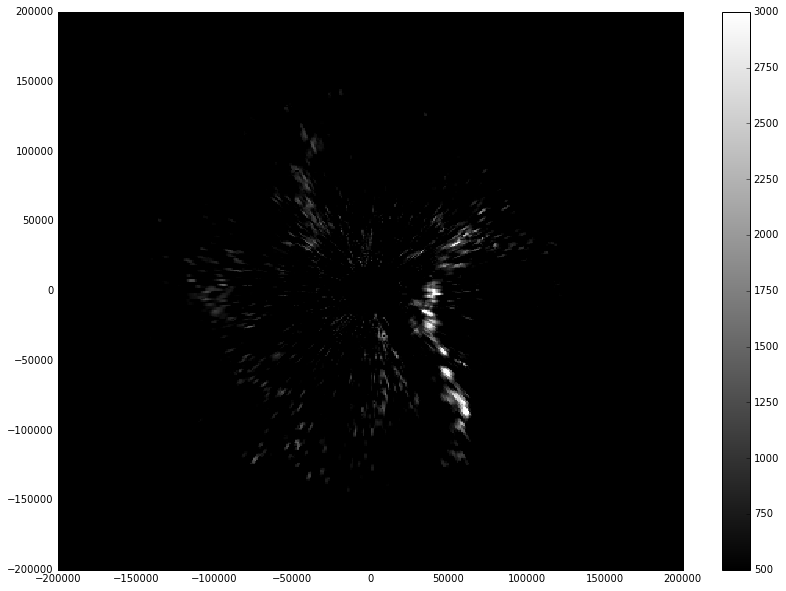

In [44]:
fig = plt.figure(figsize=(14,10))
plt.pcolormesh(xd,yd,kdp_pet,cmap=cm.gray,vmin=500,vmax=3000)
plt.colorbar()